In [2]:
from deap import base, creator, tools, algorithms
from functools import  partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")

In [3]:
df = pd.read_csv('../data/application_train_vf.csv')

In [26]:
num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [27]:
var_to_categorize = [var for var in num if df[var].nunique() < 5]

In [28]:
num_final = [var for var in num if var not in var_to_categorize]

In [34]:
variable_a_jeter = ['AMT_INCOME_TOTAL', "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"
           "HOUR_APPR_PROCESS_START", 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
           'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
           'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_PHONE', 'FLAG_EMAIL',"FLAG_MOBIL",'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', "LIVE_CITY_NOT_WORK_CITY", "CNT_CHILDREN","AMT_ANNUITY","AMT_CREDIT", "CNT_FAM_MEMBERS", "OBS_30_CNT_SOCIAL_CIRCLE"]

variable_a_garder_3_bins = ["DAYS_BIRTH", 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', "EXT_SOURCE_2"]

variable_a_garder_2_bins = ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3", "FLAG_EMP_PHONE", "REG_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY"] 

In [46]:
dict_variables = {}

for var in variable_a_garder_2_bins:
    dict_variables[var] = 1

for var in variable_a_garder_3_bins:
    dict_variables[var] = 2

In [72]:
dic = {}
for var in ['AMT_CREDIT', 'AMT_ANNUITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_PHONE']:
    dic[var] = 1

# Discrétisation

In [47]:
def calculate_stability(column):
    stability_df = df.groupby(['date_mensuelle', column])['TARGET'].mean().unstack()
    
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df

In [48]:
def plot_stability(variable):
    stability_df = calculate_stability(variable)  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [49]:
def evalChi2(individual, variable):
    individual_sorted = sorted(individual)
    percentiles = [max(0, min(i * 100, 100)) for i in individual_sorted]
    thresholds = np.percentile(df[variable].dropna(), percentiles)
    
    thresholds = np.unique(thresholds)
    
    disc_var = np.digitize(df[variable], thresholds)
    df['disc_var'] = disc_var
    
    contingency_table = pd.crosstab(df['disc_var'], df['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2,

In [50]:
def Run_Genetic_Discretisation(VARIABLE, NB_CLASSES_MAX):
    NB_GEN = 50
    POP_SIZE = 100  
    CXPB, MUTPB = 0.5, 0.2  


    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    def custom_crossover(ind1, ind2):
        if len(ind1) > 1 and len(ind2) > 1:
            return tools.cxTwoPoint(ind1, ind2)
        else:
            # Pour des individus de taille 1, retourner sans modification
            return ind1, ind2

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NB_CLASSES_MAX)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(evalChi2, variable=VARIABLE))
    toolbox.register("mate", custom_crossover)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=POP_SIZE)
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NB_GEN, verbose=False)
    
    best_ind = tools.selBest(population, 1)[0]
    return(best_ind)

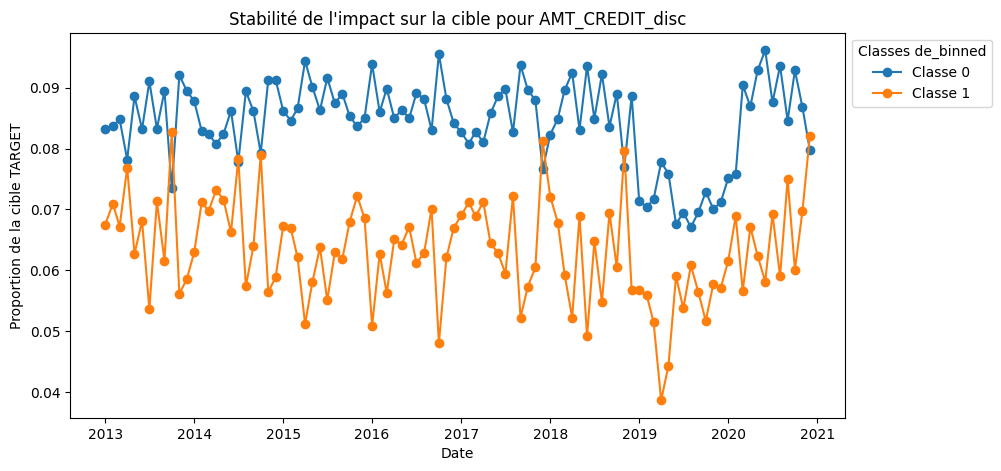

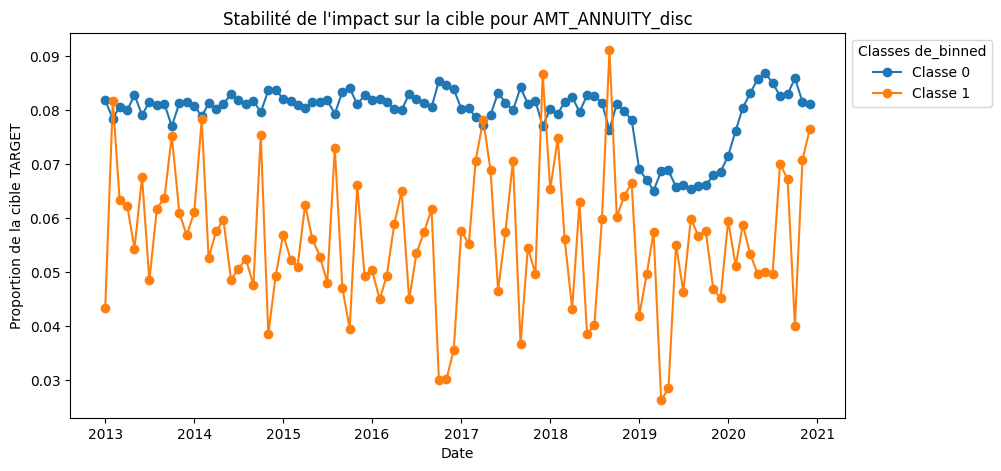

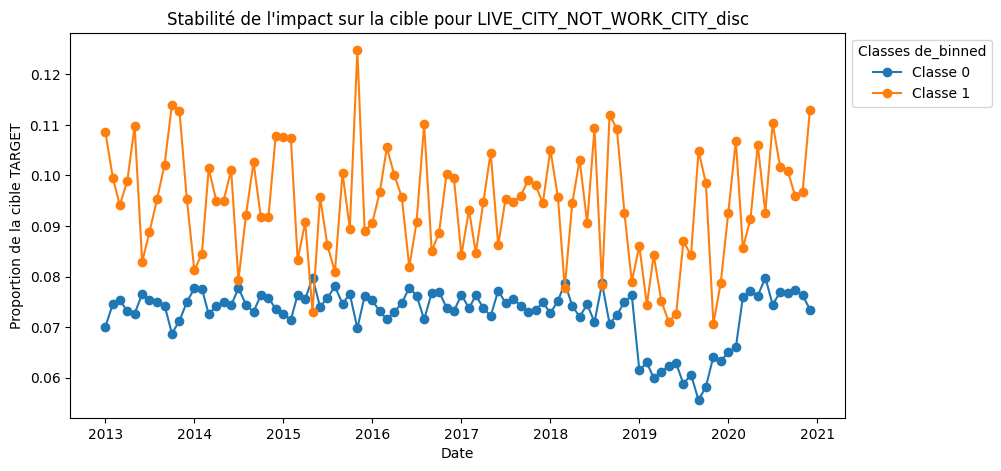

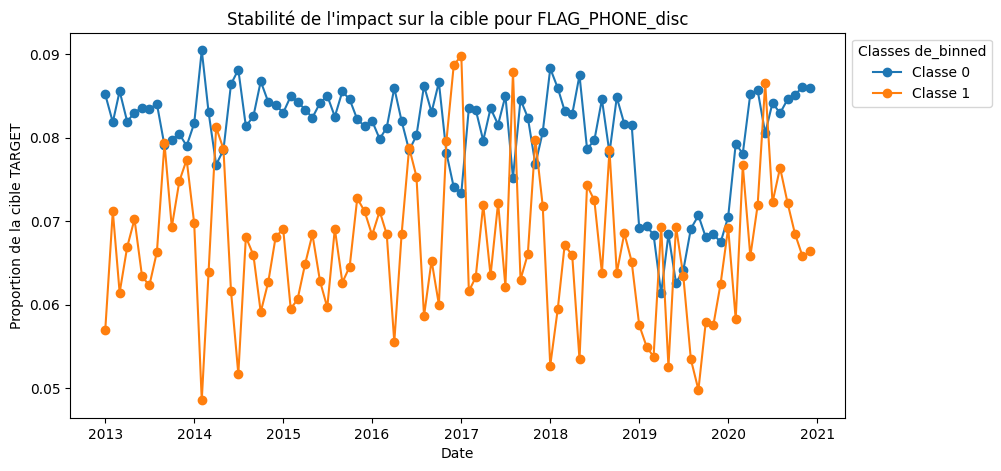

In [74]:
for variable in dic : 
    bins = Run_Genetic_Discretisation(variable, dic[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(df[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    df[f'{variable}_disc'] = np.digitize(df[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [52]:
var_good_3cat = ["DAYS_BIRTH", 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', "EXT_SOURCE_2"]

var_2_cat = ["CNT_CHILDREN", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3"]

var_categorize = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                  'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'
                  ]

var_bad = ['AMT_INCOME_TOTAL', "DAYS_ID_PUBLISH", "DAYS_REGISTRATION", "CNT_FAM_MEMBERS"
           "HOUR_APPR_PROCESS_START", 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
           'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
           'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
var_2_cat_good = ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3"] 

var_2_cat_bad = ["CNT_CHILDREN","AMT_ANNUITY","AMT_CREDIT"]

# Discretisation des catégorielles

In [4]:
var_categorize_full = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                  'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

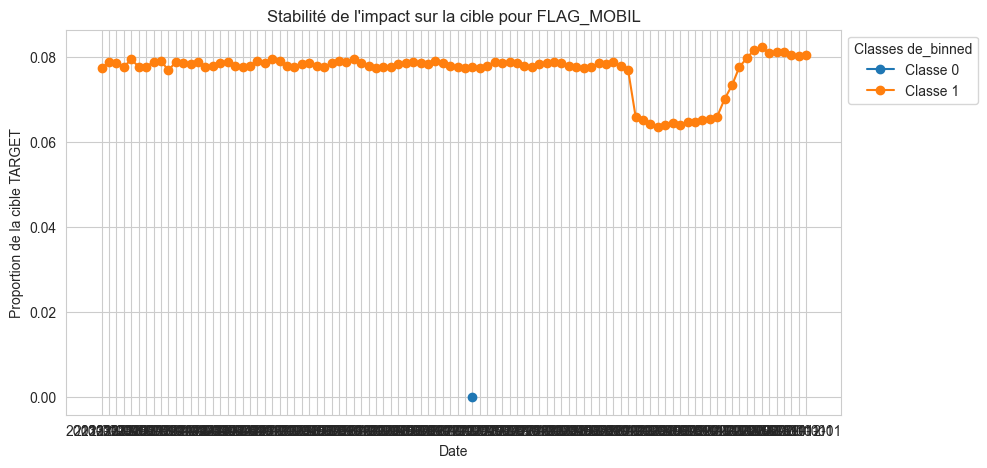

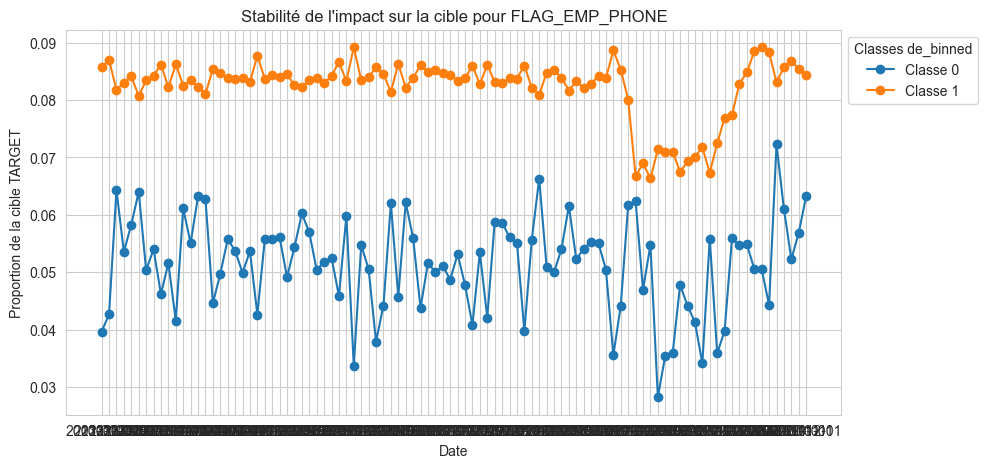

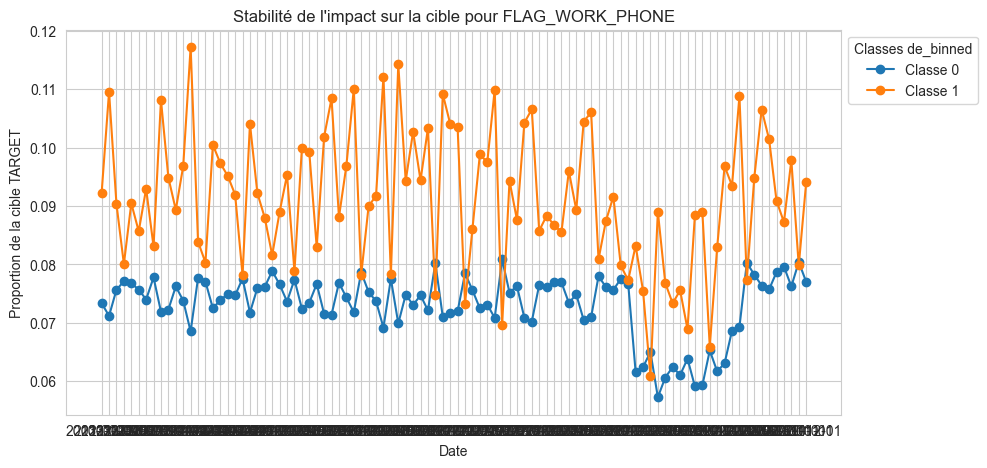

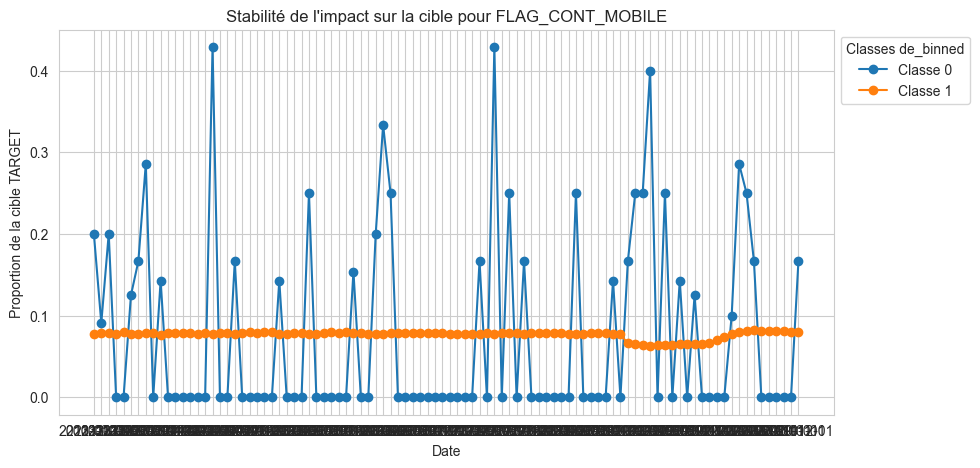

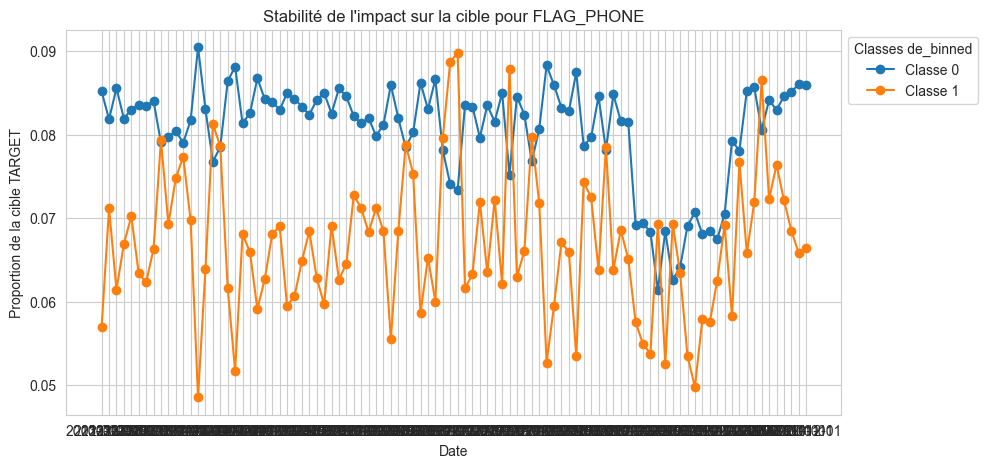

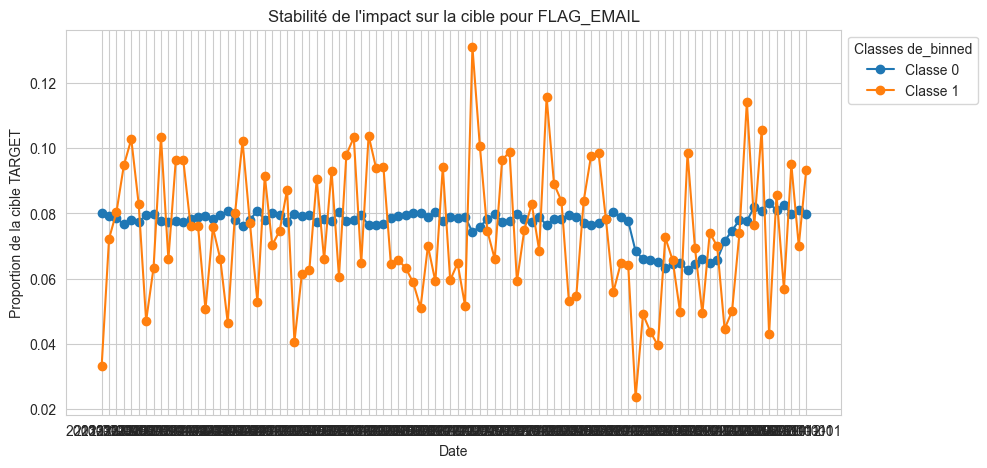

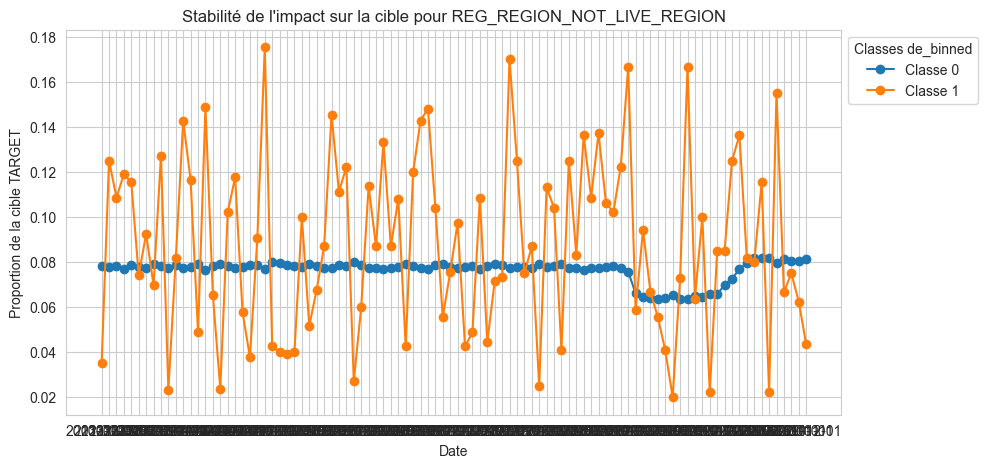

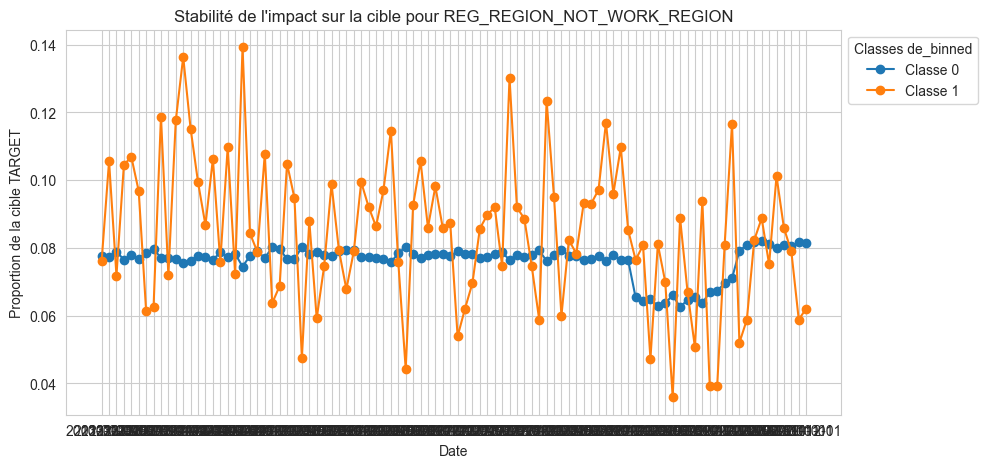

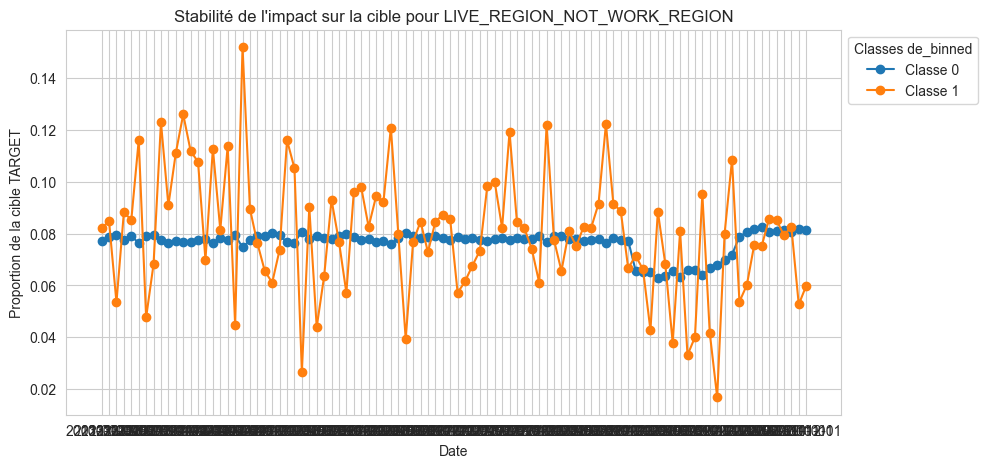

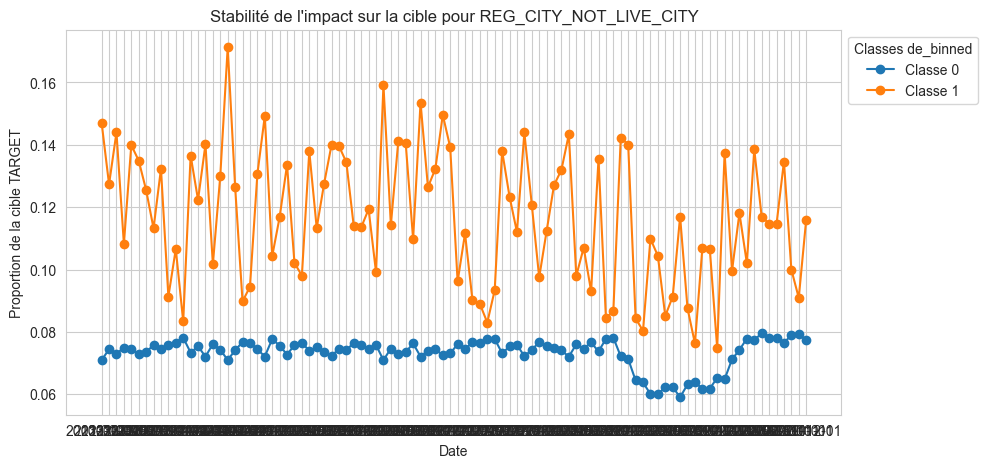

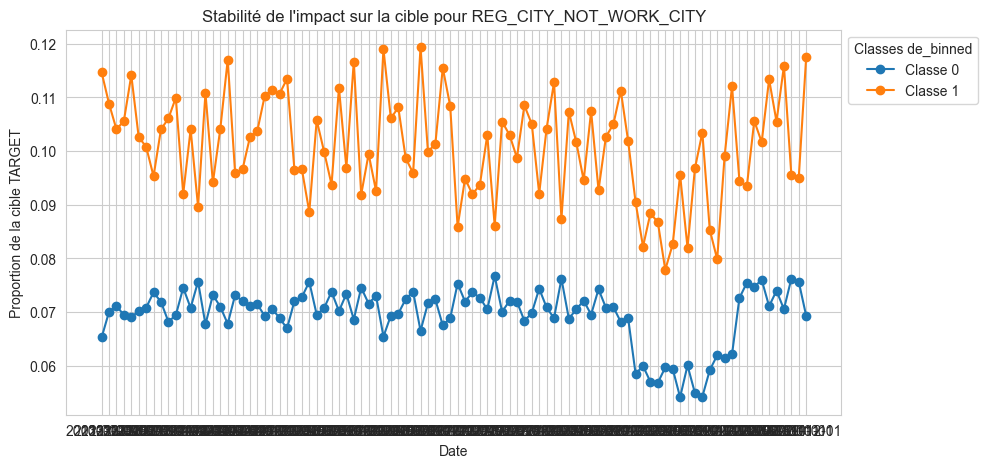

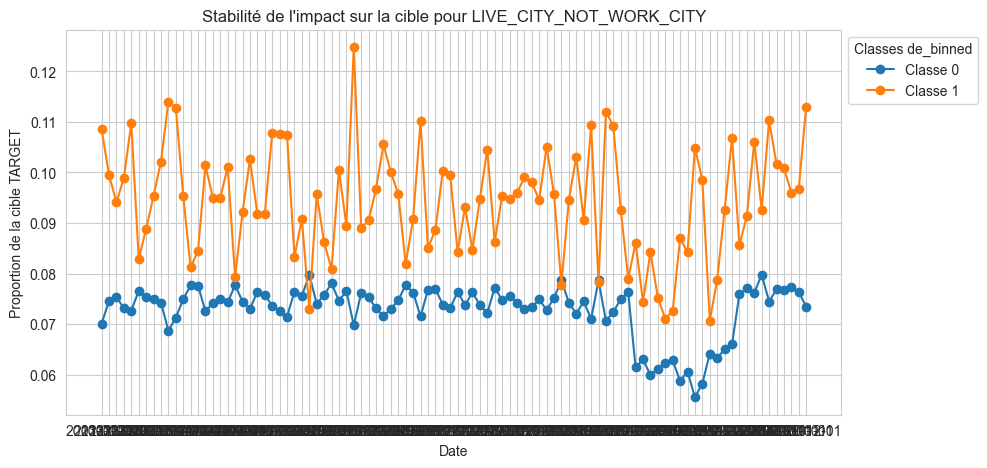

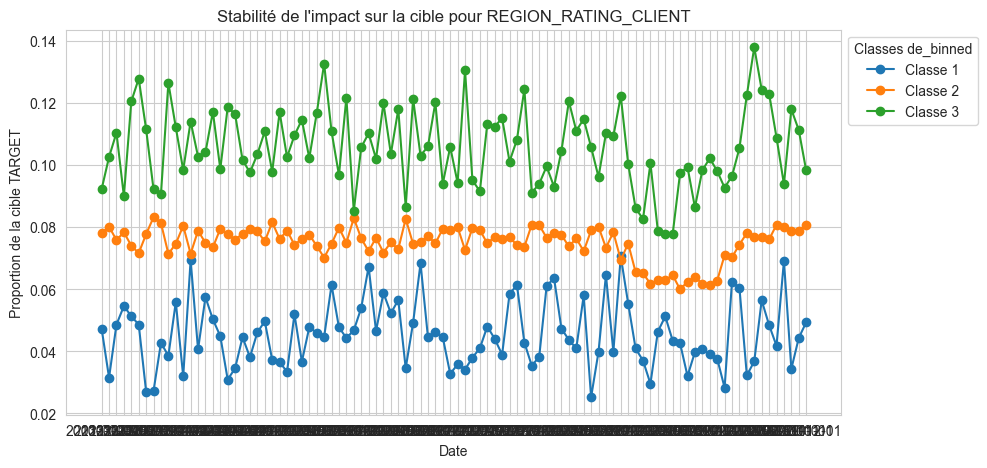

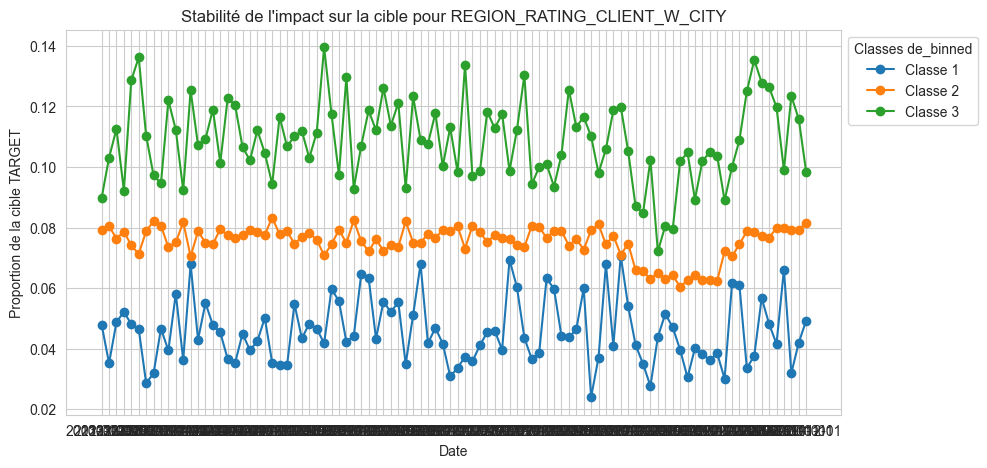

In [18]:
for var in var_categorize_full :
    plot_stability(var)

In [24]:
var_categ_good = ['FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT'
                  'REGION_RATING_CLIENT_W_CITY', "REG_CITY_NOT_WORK_CITY"]

var_categ_bad = [ 'FLAG_PHONE', 'FLAG_EMAIL',"FLAG_MOBIL",
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', "LIVE_CITY_NOT_WORK_CITY"]

# Conclusion

In [67]:
variable_a_jeter = ['AMT_INCOME_TOTAL', "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"
           "HOUR_APPR_PROCESS_START", 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
           'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
           'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_PHONE', 'FLAG_EMAIL',"FLAG_MOBIL",'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', "LIVE_CITY_NOT_WORK_CITY", "CNT_CHILDREN","AMT_ANNUITY","AMT_CREDIT", "CNT_FAM_MEMBERS", "OBS_30_CNT_SOCIAL_CIRCLE"]

variable_a_garder_3_bins = ["DAYS_BIRTH", "EXT_SOURCE_2"]

variable_a_garder_2_bins = ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3", 'AMT_CREDIT', 'AMT_ANNUITY',] 

var_cat_à_garder = ["REGION_RATING_CLIENT_W_CITY","REGION_RATING_CLIENT","FLAG_PHONE", 
 "LIVE_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "FLAG_EMP_PHONE"]

# Vérification Trimestrielle

In [75]:
var_trimestre = ["EXT_SOURCE_3", "REGION_POPULATION_RELATIVE",
                 "DAYS_EMPLOYED", "DAYS_REGISTRATION", "LIVE_CITY_NOT_WORK_CITY",
                 "REGION_RATING_CLIENT", 'AMT_CREDIT', 'AMT_ANNUITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_PHONE']

In [76]:
var_trimestre2 = [str(var + '_disc') for var in var_trimestre]

In [ ]:
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [32]:
def calculate_stability_tri(column):
    stability_df = df.groupby(['date_trimestrielle', column])['TARGET'].mean().unstack()

    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df


def plot_stability_tri(variable):
    stability_df = calculate_stability_tri(variable)
    plt.figure(figsize=(10, 5))

    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')

    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

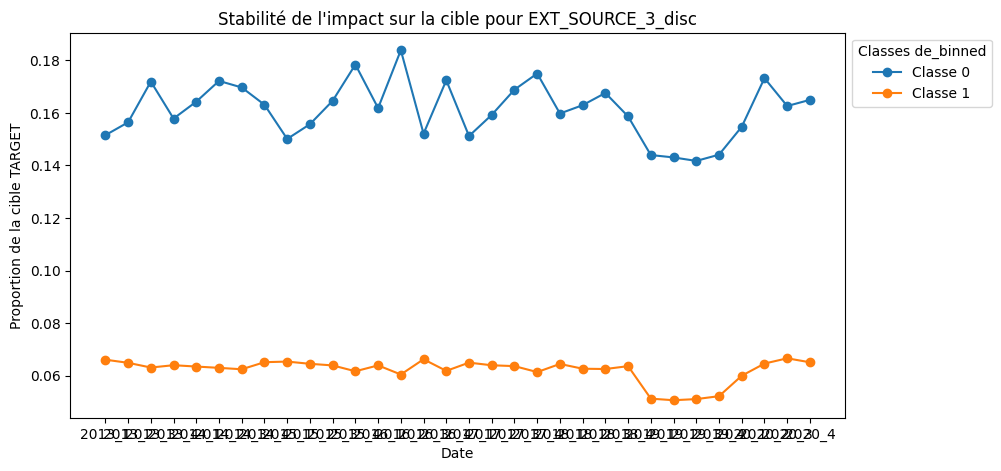

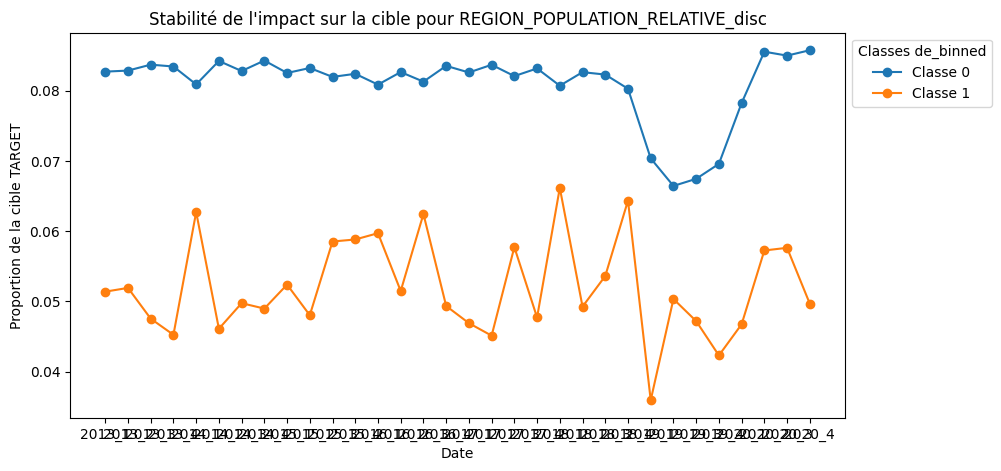

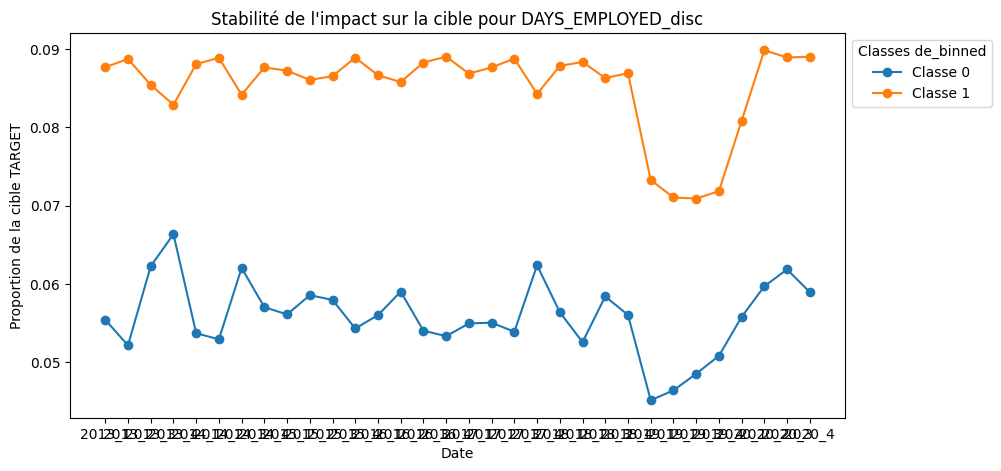

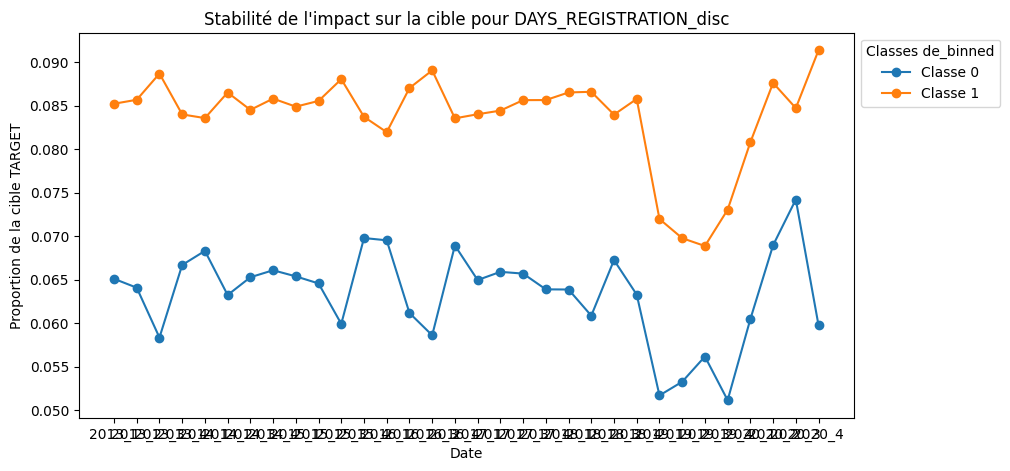

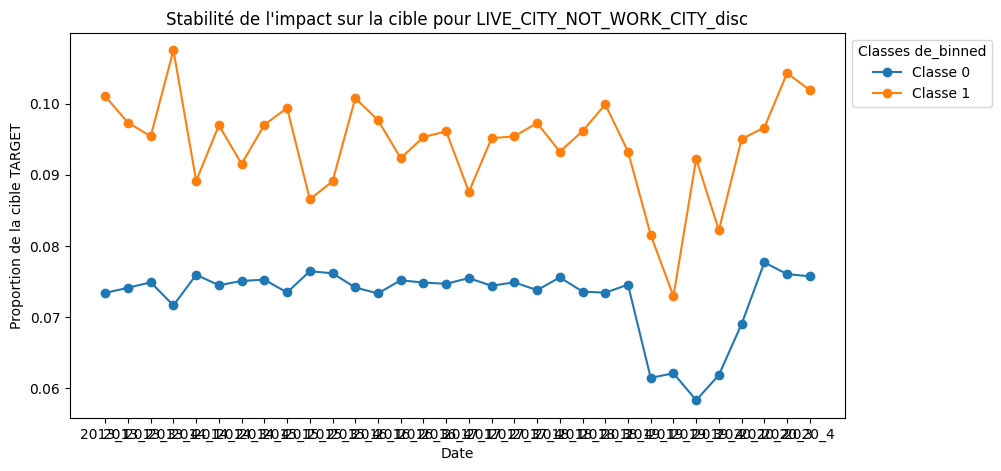

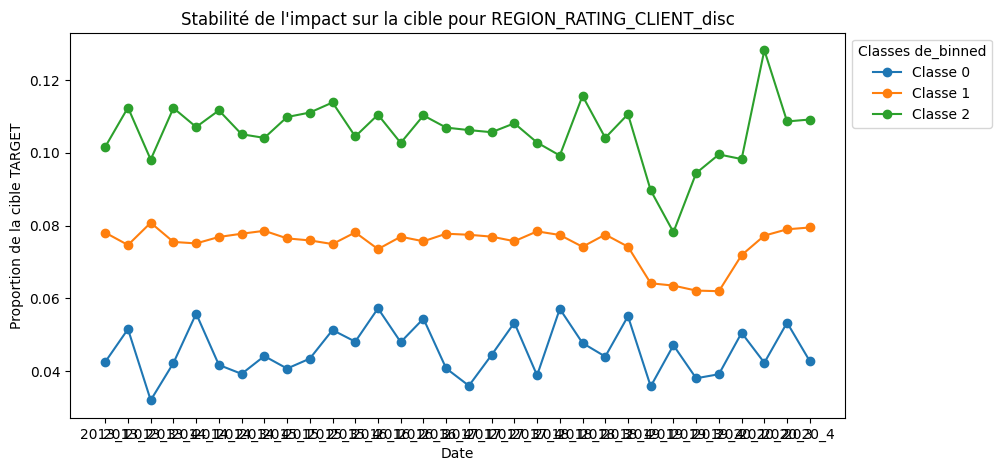

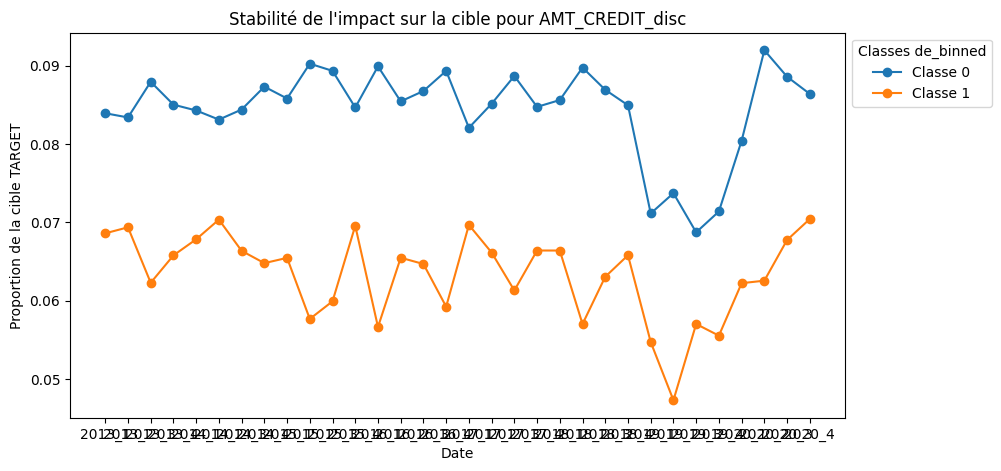

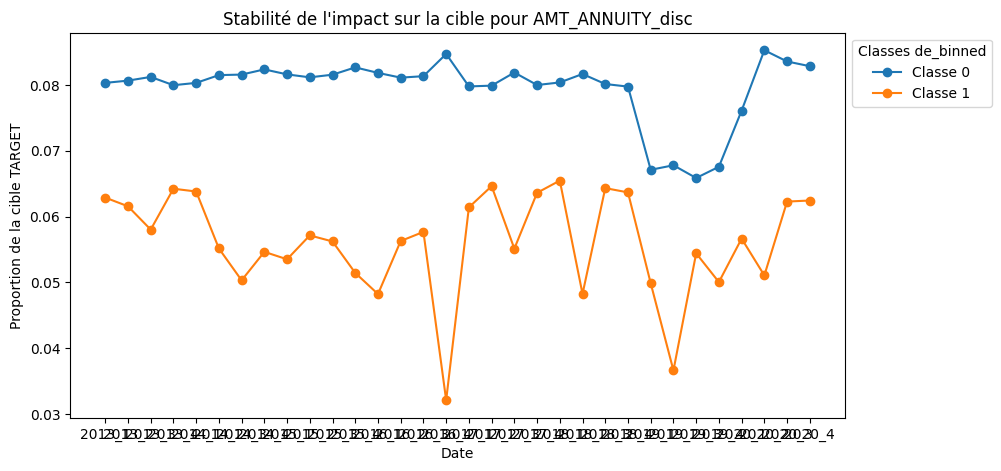

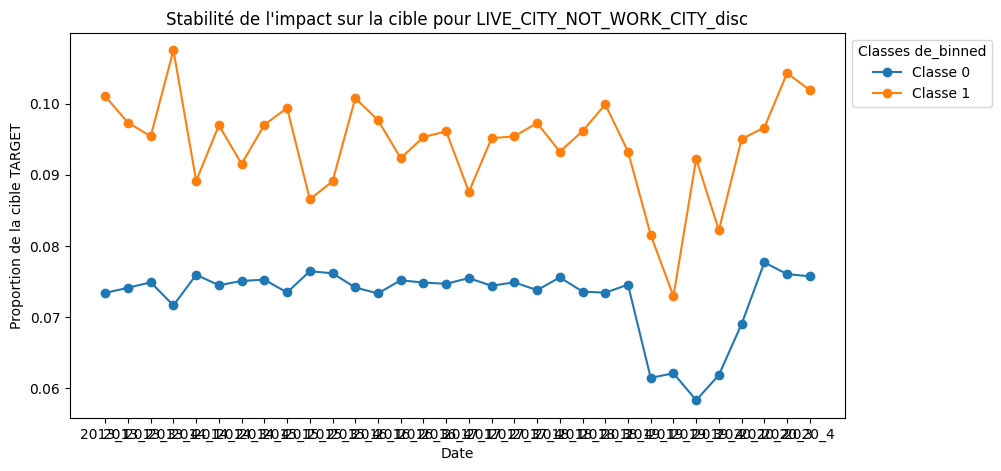

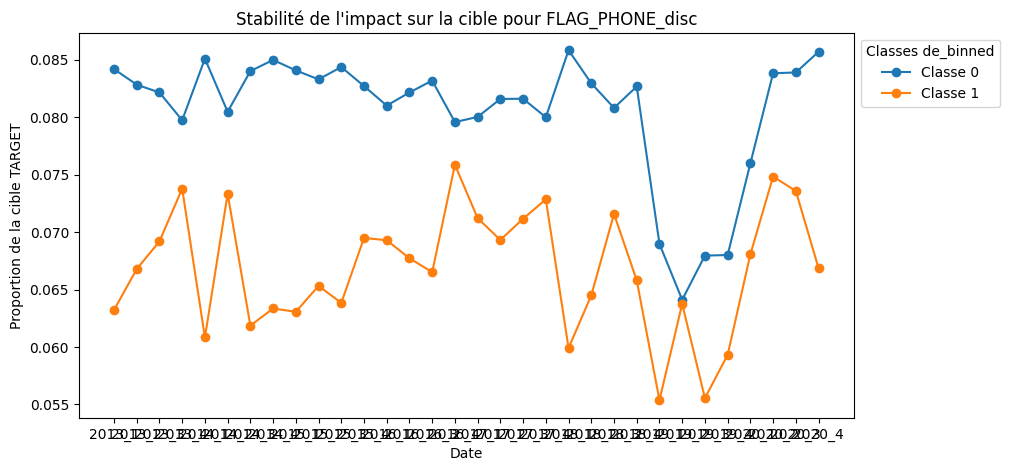

In [77]:
for var in var_trimestre2 :
    plot_stability_tri(var)

# Création des intervalles

In [82]:
all_good = ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3", "FLAG_EMP_PHONE", "REG_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY", 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_PHONE', 'AMT_CREDIT', 'AMT_ANNUITY',"DAYS_BIRTH", 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', "EXT_SOURCE_2"]

In [97]:
all_good_disc = ["AMT_GOODS_PRICE_disc", "REGION_POPULATION_RELATIVE_disc",
             "DAYS_EMPLOYED_disc", "DAYS_REGISTRATION_disc", "EXT_SOURCE_3_disc", "FLAG_EMP_PHONE_disc", "REG_CITY_NOT_WORK_CITY_disc", "REG_CITY_NOT_LIVE_CITY_disc", 'LIVE_CITY_NOT_WORK_CITY_disc', 'FLAG_PHONE_disc', 'AMT_CREDIT_disc', 'AMT_ANNUITY_disc',"DAYS_BIRTH_disc", 'REGION_RATING_CLIENT_disc', 'REGION_RATING_CLIENT_W_CITY_disc', "EXT_SOURCE_2_disc"]

In [90]:
df[["AMT_GOODS_PRICE", "AMT_GOODS_PRICE_disc"]][df["AMT_GOODS_PRICE_disc"]==2].min()

AMT_GOODS_PRICE        NaN
AMT_GOODS_PRICE_disc   NaN
dtype: float64

In [ ]:
max 1 : 4050000
min 1 : 679500
min : 40500
max : 676278

In [105]:
for var in all_good_disc : 
    var_og = var.split('_disc')[0]
    intervalles = df.groupby(var)[var_og].agg(['min', 'max'])

    dict_renommage = {modalite: f'[{round(row["min"],2)}-{round(row["max"],2)}]' for modalite, row in intervalles.iterrows()}
    
    df[f'{var}_int'] = df[var].map(dict_renommage)

In [106]:
df[["AMT_GOODS_PRICE", "AMT_GOODS_PRICE_disc", 'AMT_GOODS_PRICE_disc_int']]

,AMT_GOODS_PRICE,AMT_GOODS_PRICE_disc,AMT_GOODS_PRICE_disc_int
0,1102500.0,1,[679500.0-4050000.0]
1,270000.0,0,[40500.0-676278.0]
2,67500.0,0,[40500.0-676278.0]
3,900000.0,1,[679500.0-4050000.0]
4,225000.0,0,[40500.0-676278.0]
...,...,...,...
306102,598500.0,0,[40500.0-676278.0]
306103,270000.0,0,[40500.0-676278.0]
306104,1350000.0,1,[679500.0-4050000.0]
306105,135000.0,0,[40500.0-676278.0]


In [103]:
final = [var for var in df.columns if '_disc_int' in var]

In [107]:
df[final]

,AMT_GOODS_PRICE_disc_int,REGION_POPULATION_RELATIVE_disc_int,DAYS_EMPLOYED_disc_int,DAYS_REGISTRATION_disc_int,EXT_SOURCE_3_disc_int,FLAG_EMP_PHONE_disc_int,REG_CITY_NOT_WORK_CITY_disc_int,REG_CITY_NOT_LIVE_CITY_disc_int,LIVE_CITY_NOT_WORK_CITY_disc_int,FLAG_PHONE_disc_int,AMT_CREDIT_disc_int,AMT_ANNUITY_disc_int,DAYS_BIRTH_disc_int,REGION_RATING_CLIENT_disc_int,REGION_RATING_CLIENT_W_CITY_disc_int,EXT_SOURCE_2_disc_int
0,[679500.0-4050000.0],[0.0-0.03],[-2443-365243],[-6170.0-0.0],[0.32-0.9],[1-1],[0-0],[0-0],[0-0],[1-1],[675000.0-4050000.0],[1615.5-43794.0],[-13537--7489],[3-3],[3-3],[0.48-0.85]
1,[40500.0-676278.0],[0.0-0.03],[-17912--2444],[-6170.0-0.0],[0.32-0.9],[1-1],[0-0],[0-0],[0-0],[1-1],[45000.0-674842.5],[1615.5-43794.0],[-13537--7489],[3-3],[3-3],[0.48-0.85]
2,[40500.0-676278.0],[0.0-0.03],[-2443-365243],[-24672.0--6171.0],[0.32-0.9],[1-1],[0-0],[0-0],[0-0],[0-0],[45000.0-674842.5],[1615.5-43794.0],[-13537--7489],[2-2],[2-2],[0.48-0.85]
3,[679500.0-4050000.0],[0.03-0.07],[-2443-365243],[-24672.0--6171.0],[0.32-0.9],[1-1],[0-0],[0-0],[0-0],[0-0],[675000.0-4050000.0],[1615.5-43794.0],[-19303--13538],[1-1],[1-1],[0.48-0.85]
4,[40500.0-676278.0],[0.0-0.03],[-2443-365243],[-6170.0-0.0],[0.32-0.9],[1-1],[1-1],[1-1],[1-1],[1-1],[45000.0-674842.5],[1615.5-43794.0],[-19303--13538],[2-2],[2-2],[0.0-0.15]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306102,[40500.0-676278.0],[0.0-0.03],[-2443-365243],[-6170.0-0.0],[0.32-0.9],[0-0],[0-0],[0-0],[0-0],[0-0],[45000.0-674842.5],[1615.5-43794.0],[-19303--13538],[3-3],[3-3],[0.0-0.15]
306103,[40500.0-676278.0],[0.03-0.07],[-17912--2444],[-6170.0-0.0],[0.32-0.9],[1-1],[1-1],[0-0],[1-1],[0-0],[45000.0-674842.5],[1615.5-43794.0],[-19303--13538],[2-2],[2-2],[0.48-0.85]
306104,[679500.0-4050000.0],[0.03-0.07],[-2443-365243],[-6170.0-0.0],[0.32-0.9],[1-1],[0-0],[0-0],[0-0],[1-1],[675000.0-4050000.0],[43803.0-258025.5],[-19303--13538],[1-1],[1-1],[0.48-0.85]
306105,[40500.0-676278.0],[0.0-0.03],[-2443-365243],[-6170.0-0.0],[0.32-0.9],[0-0],[0-0],[1-1],[0-0],[0-0],[45000.0-674842.5],[1615.5-43794.0],[-25229--19304],[3-3],[3-3],[0.15-0.48]


In [109]:
for var in ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",
             "DAYS_EMPLOYED", "DAYS_REGISTRATION", "EXT_SOURCE_3", "FLAG_EMP_PHONE", "REG_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY", 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_PHONE', 'AMT_CREDIT', 'AMT_ANNUITY',"DAYS_BIRTH", 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', "EXT_SOURCE_2"]:
    print(var, df[var].nunique())

AMT_GOODS_PRICE 1000
REGION_POPULATION_RELATIVE 81
DAYS_EMPLOYED 12571
DAYS_REGISTRATION 15687
EXT_SOURCE_3 812
FLAG_EMP_PHONE 2
REG_CITY_NOT_WORK_CITY 2
REG_CITY_NOT_LIVE_CITY 2
LIVE_CITY_NOT_WORK_CITY 2
FLAG_PHONE 2
AMT_CREDIT 5597
AMT_ANNUITY 13667
DAYS_BIRTH 17460
REGION_RATING_CLIENT 3
REGION_RATING_CLIENT_W_CITY 3
EXT_SOURCE_2 119451


In [112]:
df["REGION_POPULATION_RELATIVE"]

0         0.018209
1         0.003122
2         0.018634
3         0.072508
4         0.004849
            ...   
306102    0.020246
306103    0.035792
306104    0.072508
306105    0.007305
306106    0.035792
Name: REGION_POPULATION_RELATIVE, Length: 306107, dtype: float64

In [ ]:
variable_a_garder_3_bins = ["DAYS_BIRTH_disc_int", "EXT_SOURCE_2_disc_int"]

variable_a_garder_2_bins = ["AMT_GOODS_PRICE_disc_int", "REGION_POPULATION_RELATIVE_disc_int",
             "DAYS_EMPLOYED_disc_int", "DAYS_REGISTRATION_disc_int", "EXT_SOURCE_3_disc_int", 'AMT_CREDIT_disc_int', 'AMT_ANNUITY_disc_int',] 

var_cat_à_garder = ["REGION_RATING_CLIENT_W_CITY","REGION_RATING_CLIENT","FLAG_PHONE", 
 "LIVE_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "FLAG_EMP_PHONE"]

In [113]:
all = ["DAYS_BIRTH_disc_int", "EXT_SOURCE_2_disc_int", "AMT_GOODS_PRICE_disc_int", "REGION_POPULATION_RELATIVE_disc_int",
             "DAYS_EMPLOYED_disc_int", "DAYS_REGISTRATION_disc_int", "EXT_SOURCE_3_disc_int", 'AMT_CREDIT_disc_int', 'AMT_ANNUITY_disc_int', "REGION_RATING_CLIENT_W_CITY","REGION_RATING_CLIENT","FLAG_PHONE", 
 "LIVE_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "FLAG_EMP_PHONE"]

In [115]:
final = df[all]

In [116]:
final.to_csv("../data/var_num.csv")